In [2]:
!wget https://raw.githubusercontent.com/Munazaa/Flood-Mapping-Case/main/requirements.txt



--2024-12-09 13:52:22--  https://raw.githubusercontent.com/Munazaa/Flood-Mapping-Case/main/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]      40  --.-KB/s    in 0s      

2024-12-09 13:52:22 (1.82 MB/s) - ‘requirements.txt’ saved [40/40]



In [3]:
!pip install -r requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.0 MB/s eta 0:00:00


In [5]:
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='eee-mashalahore')

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#Define AOI (Area of Interest)
#Put bbox coordinates for aoi
aoi = ee.Geometry.Polygon(
    [[[10.42, 46.29],
      [11.62, 46.29],
      [11.62, 45.73],
      [10.42, 45.73]]]
)

#Yearly Rainfall Data Analysis

CHIRPS (Climate Hazards Group InfraRed Precipitation with Station data) is a global dataset providing precipitation estimates at a spatial resolution of 0.05° (~5.5 km) and a temporal resolution of 5-day averages (pentads). It combines satellite and station data, spanning from 1981 to present. In this analysis, we focus on rainfall trends within the specified Area of Interest (aoi), visualizing pentad-based precipitation patterns.

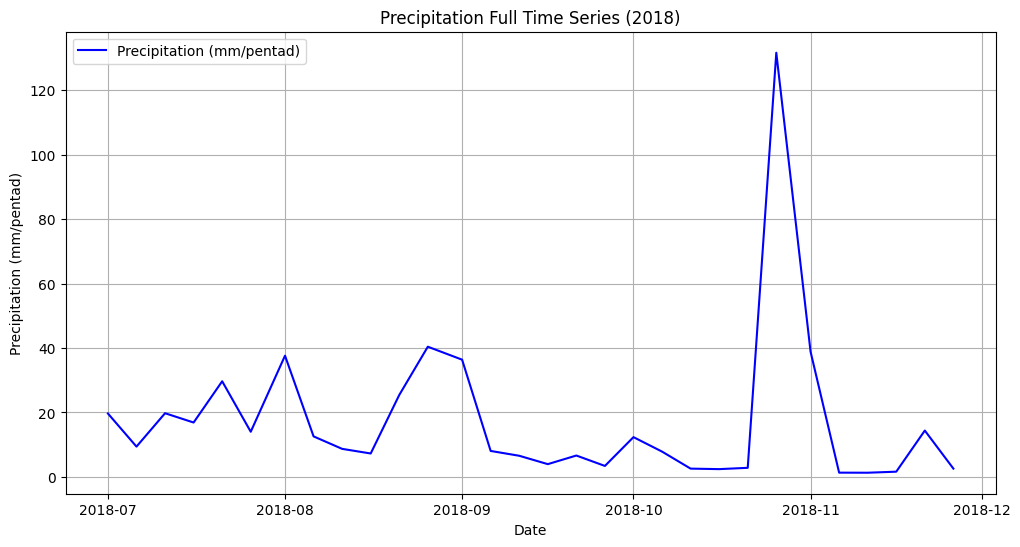

In [68]:
# Load CHIRPS data
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD') \
    .filterBounds(aoi) \
    .filterDate('2018-07-01', '2018-11-30') #choose date and year accordingly

# Function to add date as a property to each image
def add_date_property(image):
    return image.set('date', image.date().format('YYYY-MM-dd'))

# Map the function to the collection
chirps_with_date = chirps.map(add_date_property)

# Reduce the CHIRPS data to mean precipitation values over the AOI
def extract_precipitation(image):
    mean_precip = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi,
        scale=1000
    ).get('precipitation')  # Key for precipitation in CHIRPS
    return ee.Feature(None, {'date': image.get('date'), 'precipitation': mean_precip})

precipitation_features = chirps_with_date.map(extract_precipitation)

# Convert to list of dictionaries
precipitation_list = precipitation_features.getInfo()['features']

# Extract dates and precipitation into a DataFrame
data = pd.DataFrame([
    {'Date': f['properties']['date'], 'Precipitation': f['properties']['precipitation']}
    for f in precipitation_list
])

# Convert date column to datetime
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date')

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Precipitation'], color='blue', label='Precipitation (mm/pentad)')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm/pentad)')
plt.title('Precipitation Full Time Series (2018)')
plt.legend()
plt.grid(True)
plt.show()



In [69]:
import plotly.express as px

fig = px.line(data, x='Date', y='Precipitation', title='Precipitation Time Series (2018)',
              labels={'Precipitation': 'Precipitation (mm/pentad)', 'Date': 'Date'})
fig.show()


In [54]:
# Define parameters
before_start = '2018-10-05'
before_end = '2018-10-26'
after_start = '2018-10-27'
after_end = '2018-11-20'
polarization = "VV" #or 'VH' --> VH mostly is the prefered polarization for flood mapping. However, it always depends on your study area, you can select 'VV' as well.
pass_direction = "ASCENDING" #ASCENDING' or 'DESCENDING' when images are being compared use only one pass direction. Consider changing this parameter, if your image collection is empty. In some areas more Ascending images exist than than descending or the other way around.
difference_threshold = 1.25 #threshodl to be applied on the difference image (after flood- before flood). It has been chosen by trial and error. In case your
      #flood extent result shows many false-positive or negative signals,consider changing it!

# Load Sentinel-1 collection
collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarization)) \
    .filter(ee.Filter.eq('orbitProperties_pass', pass_direction)) \
    .filter(ee.Filter.eq('resolution_meters', 10)) \
    .filterBounds(aoi) \
    .select(polarization)

before_collection = collection.filterDate(before_start, before_end)
after_collection = collection.filterDate(after_start, after_end)

# Create mosaics and apply focal mean (smoothing)
before = before_collection.mosaic().clip(aoi).focal_mean(50, 'circle', 'meters')
after = after_collection.mosaic().clip(aoi).focal_mean(50, 'circle', 'meters')

# Calculate the difference and apply threshold
difference = after.divide(before)
flood_mask = difference.gt(difference_threshold)

# Refine flood mask using JRC Global Surface Water
swater = ee.Image('JRC/GSW1_0/GlobalSurfaceWater').select('seasonality')
swater_mask = swater.gte(10)
flooded = flood_mask.where(swater_mask, 0).updateMask(flood_mask)
#flooded = flooded.updateMask(swater_mask.Not())

# Calculate connected components to reduce noise
connections = flooded.connectedPixelCount(10)
flooded = flooded.updateMask(connections.gte(10))

# Add slope mask using DEM
DEM = ee.Image('WWF/HydroSHEDS/03VFDEM')
slope = ee.Terrain.slope(DEM)
flooded = flooded.updateMask(slope.lt(7)) #need to change slope values depend on the area

# Add flooded areas to map
print("Flooded areas calculated.")

# Define Sentinel-2 functions
def mask_clouds(image):
    qa = image.select('QA60')  # Sentinel-2 QA60 band for clouds
    cloud_mask = qa.bitwiseAnd(1 << 10).eq(0).And(qa.bitwiseAnd(1 << 11).eq(0))
    return image.updateMask(cloud_mask)

def calculate_ndwi(image):
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return ndwi.updateMask(ndwi).clip(aoi)

# Load Sentinel-2 collection and apply cloud masking
sentinel2 = (
    ee.ImageCollection("COPERNICUS/S2_SR")
    .filterBounds(aoi)
    .filterDate(before_start, after_end)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))  # Increased threshold from 20 to 50
    .map(mask_clouds)  # Apply cloud and shadow masking
)

# Calculate NDWI for before and after periods
s2_before_collection = sentinel2.filterDate(before_start, before_end).map(calculate_ndwi)
s2_after_collection = sentinel2.filterDate(after_start, after_end).map(calculate_ndwi)

# Check if both collections have valid data
if s2_before_collection.size().getInfo() > 0 and s2_after_collection.size().getInfo() > 0:
    # Create median composites
    s2_before = s2_before_collection.median()
    s2_after = s2_after_collection.median()

    # Calculate flood extent based on NDWI difference
    s2_flood = s2_after.subtract(s2_before).gt(0.1).rename('Flood')

    # Mask permanent water bodies
    permanent_water = ee.Image('JRC/GSW1_0/GlobalSurfaceWater').select('seasonality').gte(10)
    s2_flood = s2_flood.where(permanent_water, 0)
    # Apply mask to Sentinel-2 flood results
    s2_flood = s2_flood.updateMask(permanent_water.Not())

    print("Sentinel-2 Flood Layer calculated.")
else:
    print("No valid Sentinel-2 data available for the specified periods.")




Flooded areas calculated.
Sentinel-2 Flood Layer calculated.


In [55]:
import geemap

# Create a map and add Sentinel-1 layers
Map_S1 = geemap.Map(center=[46.0, 11.0], zoom=8)  # Adjust center and zoom level as needed

# Add before and after flood Sentinel-1 layers
Map_S1.addLayer(before, {'min': -25, 'max': 0}, 'S1 - Before Flood')
Map_S1.addLayer(after, {'min': -25, 'max': 0}, 'S1 - After Flood')

# Add Sentinel-1 flood extent layer
Map_S1.addLayer(flooded, {'palette': 'red'}, 'S1 - Flood Extent')

# Add AOI
Map_S1.addLayer(aoi, {}, 'AOI')

# Display the map
Map_S1.addLayerControl()  # Add layer control to toggle layers on/off
Map_S1



Map(center=[46.0, 11.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [56]:
import geemap

# Initialize a geemap Map object centered on the AOI
Map_S2 = geemap.Map(center=[45.95, 11.02], zoom=8)  # Adjust center to your AOI

# Check if both collections have valid data and visualize
if s2_before_collection.size().getInfo() > 0 and s2_after_collection.size().getInfo() > 0:
    # Add NDWI layers for before and after flood
    Map_S2.addLayer(s2_before, {'min': -0.2, 'max': 0.5, 'palette': ['white', 'blue']}, 'S2 - Before Flood (NDWI)')
    Map_S2.addLayer(s2_after, {'min': -0.2, 'max': 0.5, 'palette': ['white', 'blue']}, 'S2 - After Flood (NDWI)')

    # Add flood extent layer
    Map_S2.addLayer(s2_flood, {'palette': 'red'}, 'S2 - Flood Extent')

    # Add AOI for reference
    Map_S2.addLayer(aoi, {}, 'AOI')
else:
    print("No valid Sentinel-2 data available for visualization.")

# Display the map
Map_S2.addLayerControl()  # Add layer controls
Map_S2


Map(center=[45.95, 11.02], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [39]:
print("S2 Before Collection Size:", s2_before_collection.size().getInfo())
print("S2 After Collection Size:", s2_after_collection.size().getInfo())


S2 Before Collection Size: 20
S2 After Collection Size: 12


#Export Layers in Raster and Vector

In [15]:
# Export Sentinel-2 raster
task_s2_raster = ee.batch.Export.image.toDrive(
        image=s2_flood,
        description='Sentinel-2_Flood_Raster',
        fileNamePrefix='Sentinel2_Flood',
        folder='Flood_Analysis', # Specify the Google Drive folder here
        region=aoi,
        scale=10,
        maxPixels=1e10
    )
task_s2_raster.start()

    # Convert flood raster to vectors
s2_flood_vec = s2_flood.reduceToVectors(
        scale=10,
        geometryType='polygon',
        geometry=aoi,
        eightConnected=False,
        bestEffort=True
    )

    # Export Sentinel-2 vector
task_s2_vector = ee.batch.Export.table.toDrive(
        collection=s2_flood_vec,
        description='Sentinel-2_Flood_Vector',
        fileFormat='SHP',
        folder='Flood_Analysis' # Specify the Google Drive folder here

    )
task_s2_vector.start()


# Export Sentinel-1 Flood Raster
task_s1_raster = ee.batch.Export.image.toDrive(
    image=flooded,
    description='Sentinel-1_Flood_Raster',
    fileNamePrefix='Sentinel1_Flood',
    folder='Flood_Analysis', # Specify the Google Drive folder here
    region=aoi,
    scale=10,
    maxPixels=1e10
)
task_s1_raster.start()

# Convert Sentinel-1 flood raster to vectors
flooded_vec = flooded.reduceToVectors(
    scale=10,
    geometryType='polygon',
    geometry=aoi,
    eightConnected=False,
    bestEffort=True
)

# Export Sentinel-1 Flood Vector
task_s1_vector = ee.batch.Export.table.toDrive(
    collection=flooded_vec,
    description='Sentinel-1_Flood_Vector',
    fileFormat='SHP',
    folder='Flood_Analysis' # Specify the Google Drive folder here
)
task_s1_vector.start()

print("Export tasks started.")

Export tasks started.


#Post-Processing
This version of the code provides an initial estimation of flood detection but requires further post-processing steps to enhance accuracy. These include refining the thresholds, integrating auxiliary datasets, and improving water body masking, which are currently underway.